In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import pandas as pd
cwd=os.getcwd()
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from PIL import Image
from sklearn.preprocessing import LabelEncoder

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [6]:
df = pd.read_csv("file2.csv") 

In [8]:
#Defining VGG Model and customizing it 
direc='Data/50k/images'

datagen=ImageDataGenerator(validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=direc,
    x_col="image",
    y_col=['valence', 'Arousal', 'expression'],
    image_size=(224,224),
    batch_size=5,
    class_mode="multi_output",
    subset='training',
    shuffle=True,
    seed=42)

valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=direc,
    x_col="image",
    y_col=['valence', 'Arousal', 'expression'],
    image_size=(224,224),
    batch_size=5,
    class_mode="multi_output",
    subset='validation',
    shuffle=True,
    seed=42
)


Found 22090 validated image filenames.
Found 5522 validated image filenames.


In [9]:
model = VGG16(include_top=False, input_shape=(224, 224, 3))

for layer in model.layers:
	layer.trainable = False
    
# add new classifier layers
out =GlobalAveragePooling2D()(model.layers[-1].output)
class2 = Dense(512, activation='relu')(out)
class3=Dense(512, activation='relu')(class2)

exp_1 = Dense(100, activation='relu')(class3)
exp_2=Dense(100, activation='relu')(exp_1)
expression = Dense(8, activation='softmax',name='expression')(exp_2)

val_1 = Dense(100, activation='relu')(class3)
val_2=Dense(100, activation='relu')(val_1)
valence=keras.layers.Dense(1, activation='linear',name='valence')(val_2)

arrousal_1 = Dense(100, activation='relu')(class3)
arrousal_2=Dense(100, activation='relu')(val_1)
arrousal=keras.layers.Dense(1, activation='linear',name='arrousal')(arrousal_2)
# define new model
model = Model(inputs=model.inputs, outputs=[expression,valence,arrousal])
# summarize
model.summary()

print("completed")

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                             

In [ ]:
keras.utils.plot_model(model, "my_first_model.png")

In [10]:
from tensorflow.python.ops.math_ops import reduce_mean
#loss and optimizer

def WeightedSoftmax(y_true, y_pred):
  class_weight=tf.convert_to_tensor(np.array([0.57261169,0.57229192,0.62097051,0.7573698,1.21360446,1.21360446,1.80900564,0.62412396,1.83002202]),dtype=tf.float32)
  unreduced_scee=tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  loss =unreduced_scee(y_true, y_pred)
  weight_mask=tf.gather(class_weight, y_true)
  loss=tf.math.multiplt(loss, weight_mask)
  loss=tf.reduce_mean

loss1=tf.keras.losses.SparseCategoricalCrossentropy(reduction="auto", name="CCE")
loss2=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
loss3=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
optim=keras.optimizers.Adam(lr=0.001)
metrics=['accuracy']

losses={
    "expression":loss1,
    "valence":loss2,
    "arrousal":loss3
}


model.compile(loss=losses,optimizer=optim,metrics=metrics,loss_weights=[10,1,1])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [12]:
history=model.fit(
    train_generator,
    batch_size=64,
    epochs=10,
    steps_per_epoch=300,
    validation_data=valid_generator,
    validation_steps=10,callbacks=[cp_callback],
    verbose="auto",
    shuffle=True
)

Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 4.2507 - expression_loss: 0.0124 - valence_loss: 0.2028 - arrousal_loss: 3.9236 - expression_accuracy: 0.0260 - valence_accuracy: 0.0333 - arrousal_accuracy: 0.4393
Epoch 1: saving model to training_3/cp.ckpt
300/300 [==============================] - 341s 1s/step - loss: 4.2507 - expression_loss: 0.0124 - valence_loss: 0.2028 - arrousal_loss: 3.9236 - expression_accuracy: 0.0260 - valence_accuracy: 0.0333 - arrousal_accuracy: 0.4393 - val_loss: 3.9310 - val_expression_loss: 0.0000e+00 - val_valence_loss: 0.1194 - val_arrousal_loss: 3.8116 - val_expression_accuracy: 0.0200 - val_valence_accuracy: 0.0600 - val_arrousal_accuracy: 0.4400
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 3.3858 - expression_loss: 1.6322e-07 - valence_loss: 0.1079 - arrousal_loss: 3.2779 - expression_accuracy: 0.0180 - valence_accuracy: 0.0313 - arrousal_accuracy: 0.4487
Epoch 2: saving model to training_3/cp.ckpt
300/

Training Curve

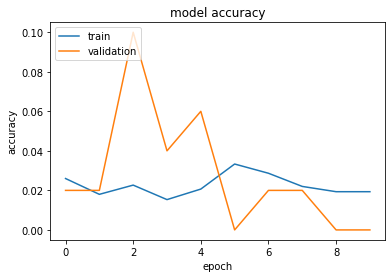

In [13]:
plt.plot(history.history['expression_accuracy'])
plt.plot(history.history['val_expression_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

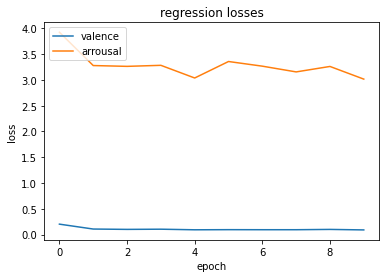

In [14]:
plt.plot(history.history['valence_loss'])
plt.plot(history.history['arrousal_loss'])
plt.title('regression losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['valence','arrousal'], loc='upper left')
plt.show()

In [15]:
df1 = pd.read_csv("test.csv") 

In [16]:
direc='test/te/images'

datagen_X=ImageDataGenerator(validation_split=0.2,preprocessing_function =tf.keras.applications.xception.preprocess_input)

test_generator_X = datagen_X.flow_from_dataframe(
    dataframe=df1,
    directory=direc,
    x_col="image",
    y_col=['valence', 'Arousal', 'expression'],
    image_size=(224,224),
    batch_size=1,
    class_mode="multi_output",
    shuffle=True,
    seed=42)

Found 2000 validated image filenames.


In [21]:
loss,expression_loss,valence_loss,arrousal_loss,expression_accuracy,valence_accuracy,arrousal_accuracy = model.evaluate(test_generator_X, verbose=1)

2000/2000 [==============================] - 94s 47ms/step - loss: 3.4056 - expression_loss: 0.0000e+00 - valence_loss: 0.0950 - arrousal_loss: 3.3106 - expression_accuracy: 0.0275 - valence_accuracy: 0.0425 - arrousal_accuracy: 0.4305


In [17]:
expression_1,valence,arousal = model.predict(test_generator_X, verbose=1)

2000/2000 [==============================] - 411s 205ms/step


In [18]:
s_array = df1[["expression"]].to_numpy()

In [19]:
y_pred = np.argmax(expression_1, axis=1)

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, s_array))

              precision    recall  f1-score   support

           0       1.00      0.30      0.46      2000
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.30      2000
   macro avg       0.12      0.04      0.06      2000
weighted avg       1.00      0.30      0.46      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
